<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [87]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

sns.set(style="darkgrid", font_scale=1.4)
import random

random.seed(10)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [88]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

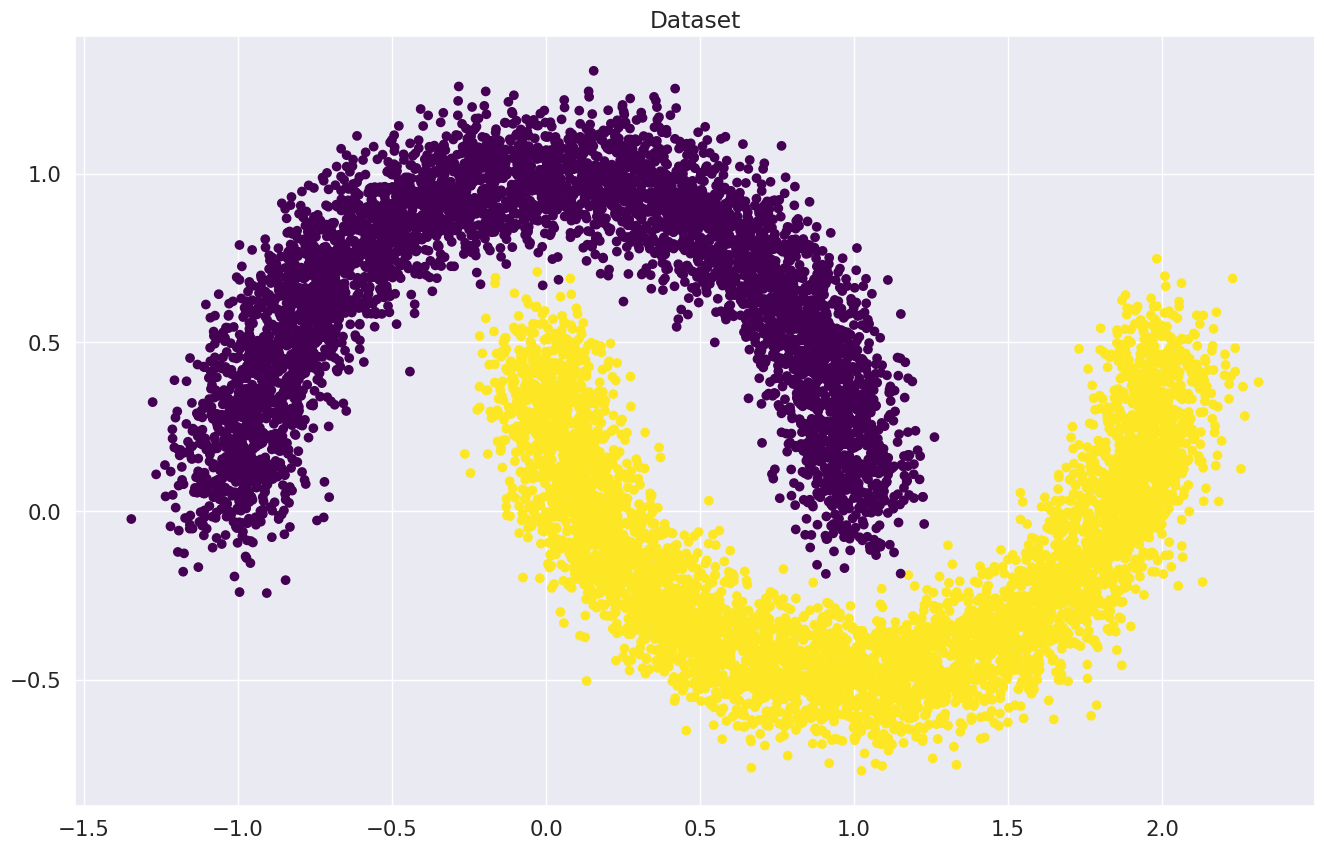

In [89]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [90]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [91]:
X_train_t =  torch.FloatTensor(X_train) # YOUR CODE GOES HERE
y_train_t = torch.FloatTensor(y_train)# YOUR CODE GOES HERE
X_val_t = torch.FloatTensor(X_val) # YOUR CODE GOES HERE
y_val_t =  torch.FloatTensor(y_val)# YOUR CODE GOES HERE

Создаем `Dataset` и `DataLoader`. 

In [92]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, drop_last=True)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут 
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [93]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(1))# YOUR CODE GOES HERE

    def forward(self, x):
        x = x @ self.weights # YOUR CODE GOES HERE
        if self.bias:
            x +=  self.bias_term # YOUR CODE GOES HERE       
        return x

In [94]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

В данной реализации 3 параметра, в общем виде in_features+1

### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [95]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch)# YOUR CODE. Use linear_regression to get outputs
       
        loss =  loss_function(outp, y_batch)# YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = nn.functional.sigmoid(outp) # YOUR CODE. Compute probabilities  
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)        
        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

/home/luna/Luna/Work/python/venv_gan/lib/python3.10/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Iteration: 0
Batch accuracy: 0.28125
Iteration: 100
Batch accuracy: 0.5546875
Iteration: 200
Batch accuracy: 0.796875
Iteration: 300
Batch accuracy: 0.796875
Iteration: 400
Batch accuracy: 0.8203125
Iteration: 500
Batch accuracy: 0.7421875
Iteration: 600
Batch accuracy: 0.8515625
Iteration: 700
Batch accuracy: 0.8515625
Iteration: 800
Batch accuracy: 0.875
Iteration: 900
Batch accuracy: 0.8203125

Iteration: 975.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 975. Каждый раз по разному, было и 47 и 863 и 685

### Визуализируем результаты

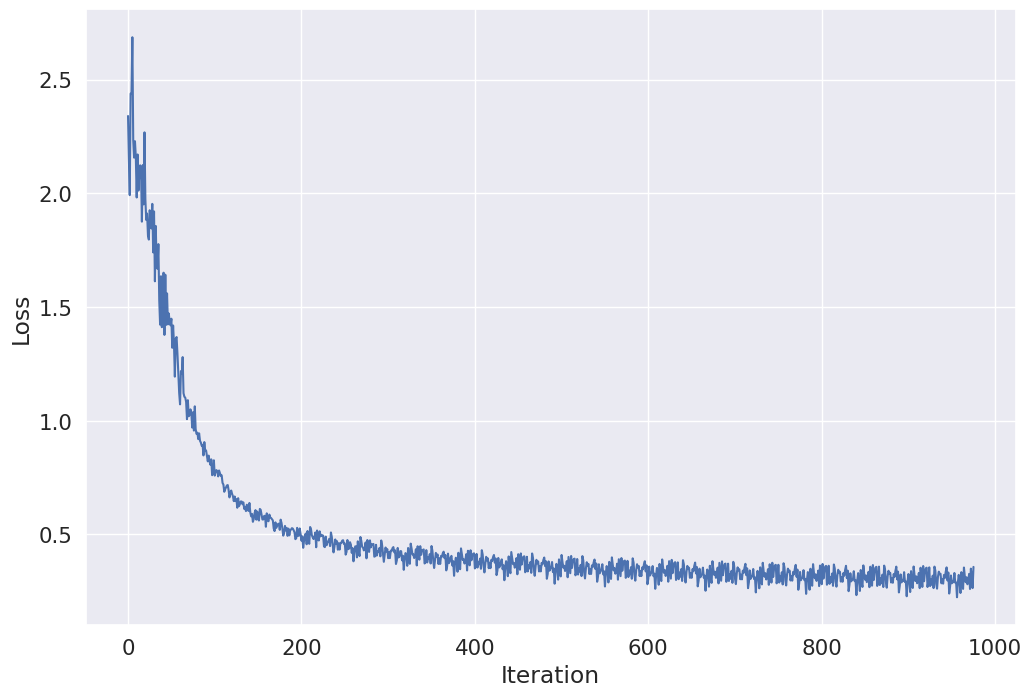

In [96]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

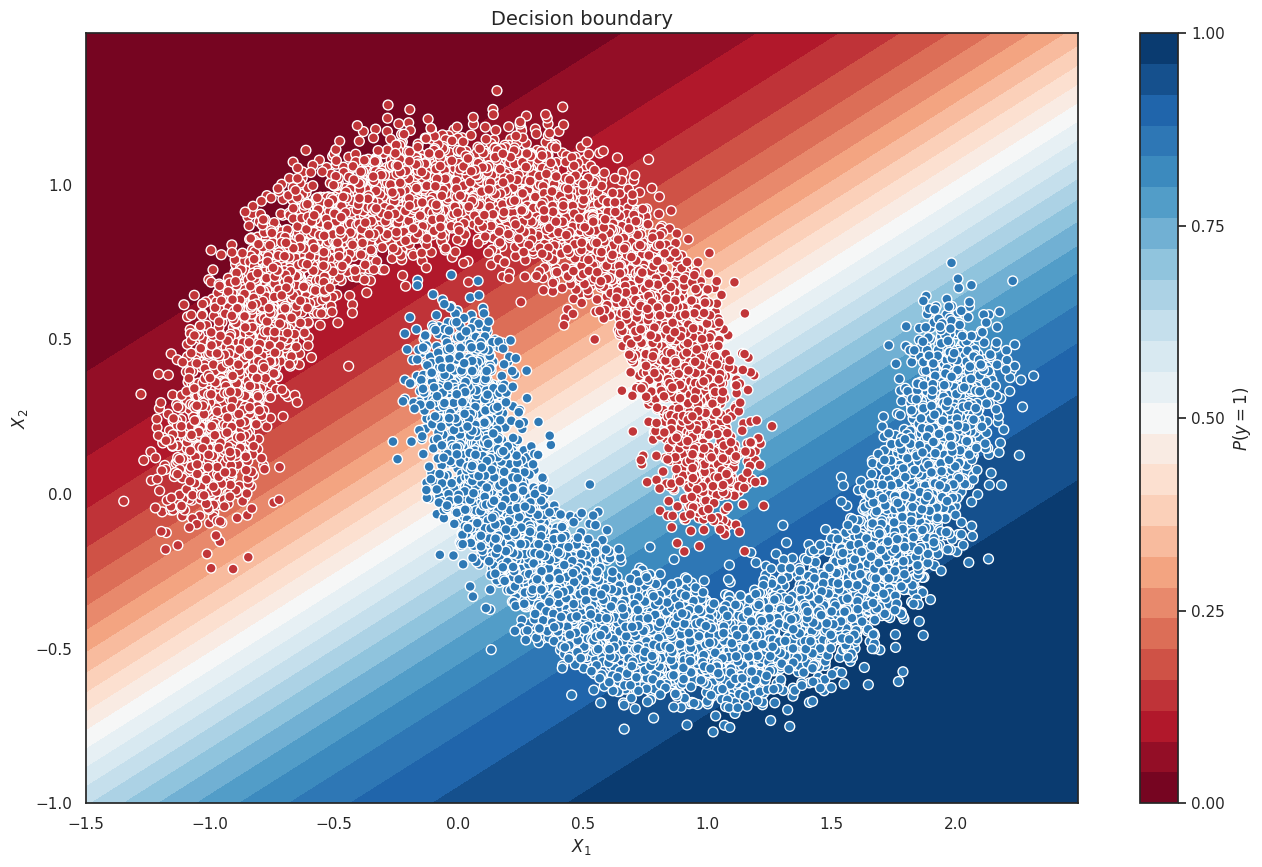

In [97]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
   
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))    
    probs = probs.numpy().reshape(xx.shape)
    
f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [98]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        probabilities = torch.sigmoid(model(x_batch))#YOUR CODE. Compute predictions
        preds = (probabilities > 0.5).type(torch.long)
        predictions = np.hstack((predictions, preds.numpy().flatten()))
    return predictions.flatten()

In [99]:
from sklearn.metrics import accuracy_score

preds = predict(val_dataloader, linear_regression)

y_val_drop_last = y_val[: y_val.shape[0] - (y_val.shape[0] % 128 )]

acc = accuracy_score(y_val_drop_last, preds)
print("Accuracy is  ", acc)
# YOUR CODE. Compute total accuracy

Accuracy is   0.859375


**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:**  0.8593
Отличается на разных запусках программы. 

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [100]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs

data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size = 128, drop_last = True) # YOUR CODE GOES HERE
valid_dataloader =  DataLoader(val_dataset, batch_size = 128, drop_last = True) # YOUR CODE GOES HERE

## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [101]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть 

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [102]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=784, out_features=128),
    activation(),
    nn.Linear(in_features=128, out_features=10)
    #YOUR CODE. Add layers to your sequential class
)

In [103]:
criterion =  nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [104]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [105]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
            # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)

            else:
            # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all = y_batch.shape[0] # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                # делаем шаг градиентного спуска
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all)        

Epoch: 1
Loader: train. Accuracy: 0.8733974358974359
Loader: valid. Accuracy: 0.9177684294871795
Epoch: 2
Loader: train. Accuracy: 0.9291700053418803
Loader: valid. Accuracy: 0.9420072115384616
Epoch: 3
Loader: train. Accuracy: 0.9513888888888888
Loader: valid. Accuracy: 0.9547275641025641
Epoch: 4
Loader: train. Accuracy: 0.9631076388888888
Loader: valid. Accuracy: 0.9620392628205128
Epoch: 5
Loader: train. Accuracy: 0.9699519230769231
Loader: valid. Accuracy: 0.9682491987179487
Epoch: 6
Loader: train. Accuracy: 0.9746427617521367
Loader: valid. Accuracy: 0.9693509615384616
Epoch: 7
Loader: train. Accuracy: 0.9786324786324786
Loader: valid. Accuracy: 0.9689503205128205
Epoch: 8
Loader: train. Accuracy: 0.9814202724358975
Loader: valid. Accuracy: 0.9699519230769231
Epoch: 9
Loader: train. Accuracy: 0.9842414529914529
Loader: valid. Accuracy: 0.9697516025641025
Epoch: 10
Loader: train. Accuracy: 0.9861278044871795
Loader: valid. Accuracy: 0.9692508012820513


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [107]:
elu_accuracy = accuracy["valid"]

In [108]:
# YOUR CODE. Do the same thing with other activations (it's better to wrap into a function that returns a list of accuracies)

def test_activation_function(activation):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=784, out_features=128),
        activation(),
        nn.Linear(in_features=128, out_features=10)
    
    )
    criterion =  nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
    optimizer = torch.optim.Adam(model.parameters())

    loaders = {"train": train_dataloader, "valid": valid_dataloader}
    device = "cuda" if torch.cuda.is_available() else "cpu"
    max_epochs = 10
    accuracy = {"train": [], "valid": []}
    
    for epoch in range(max_epochs):
        for k, dataloader in loaders.items():
            epoch_correct = 0
            epoch_all = 0
            for x_batch, y_batch in dataloader:
                if k == "train":
                # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                    model.train()
                    optimizer.zero_grad()
                    outp = model(x_batch)
    
                else:
                # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                    model.eval()
                    with torch.no_grad():
                        outp = model(x_batch)
                preds = outp.argmax(-1)
                correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
                all = y_batch.shape[0] # YOUR CODE GOES HERE
                epoch_correct += correct.item()
                epoch_all += all
                if k == "train":
                    loss = criterion(outp, y_batch)
                    # YOUR CODE. Calculate gradients and make a step of your optimizer
                    # делаем шаг градиентного спуска
                    loss.backward()
                    optimizer.step()
    
            if k == "train":
                print(f"Epoch: {epoch + 1}")
            print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
            accuracy[k].append(epoch_correct / epoch_all)           
            
    return accuracy["valid"]

In [109]:
plain_accuracy = test_activation_function(Identical)
relu_accuracy = test_activation_function(nn.ReLU)
leaky_relu_accuracy = test_activation_function(nn.LeakyReLU)

Epoch: 1
Loader: train. Accuracy: 0.8672709668803419
Loader: valid. Accuracy: 0.9025440705128205
Epoch: 2
Loader: train. Accuracy: 0.9005575587606838
Loader: valid. Accuracy: 0.9026442307692307
Epoch: 3
Loader: train. Accuracy: 0.9051148504273504
Loader: valid. Accuracy: 0.905448717948718
Epoch: 4
Loader: train. Accuracy: 0.9074185363247863
Loader: valid. Accuracy: 0.9073517628205128
Epoch: 5
Loader: train. Accuracy: 0.9089209401709402
Loader: valid. Accuracy: 0.9084535256410257
Epoch: 6
Loader: train. Accuracy: 0.9101395566239316
Loader: valid. Accuracy: 0.9084535256410257
Epoch: 7
Loader: train. Accuracy: 0.9107238247863247
Loader: valid. Accuracy: 0.9087540064102564
Epoch: 8
Loader: train. Accuracy: 0.9115084134615384
Loader: valid. Accuracy: 0.9084535256410257
Epoch: 9
Loader: train. Accuracy: 0.9127103365384616
Loader: valid. Accuracy: 0.9086538461538461
Epoch: 10
Loader: train. Accuracy: 0.9134782318376068
Loader: valid. Accuracy: 0.9088541666666666
Epoch: 1
Loader: train. Accura

### Accuracy
Построим график accuracy/epoch для каждой функции активации.

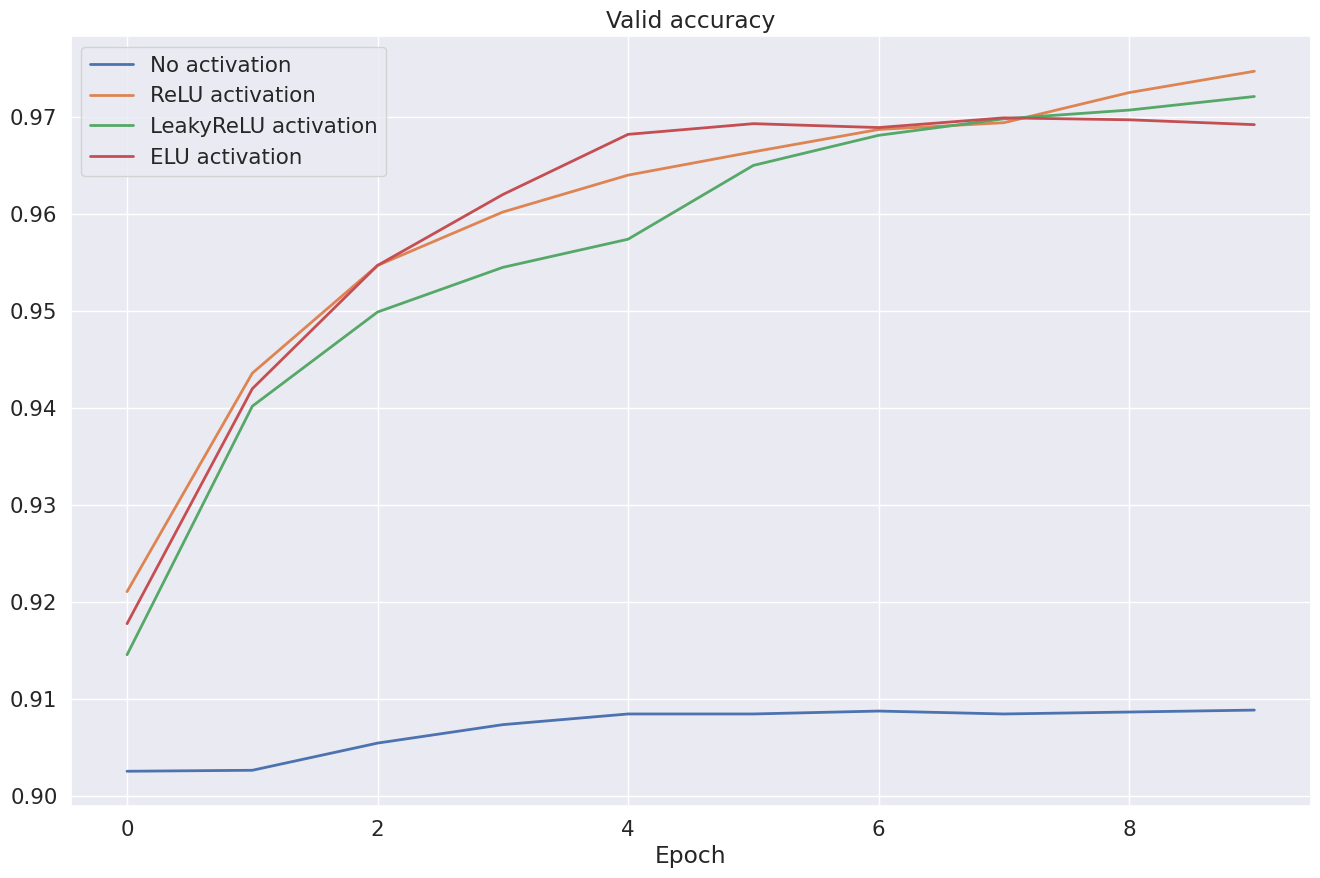

In [110]:
sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

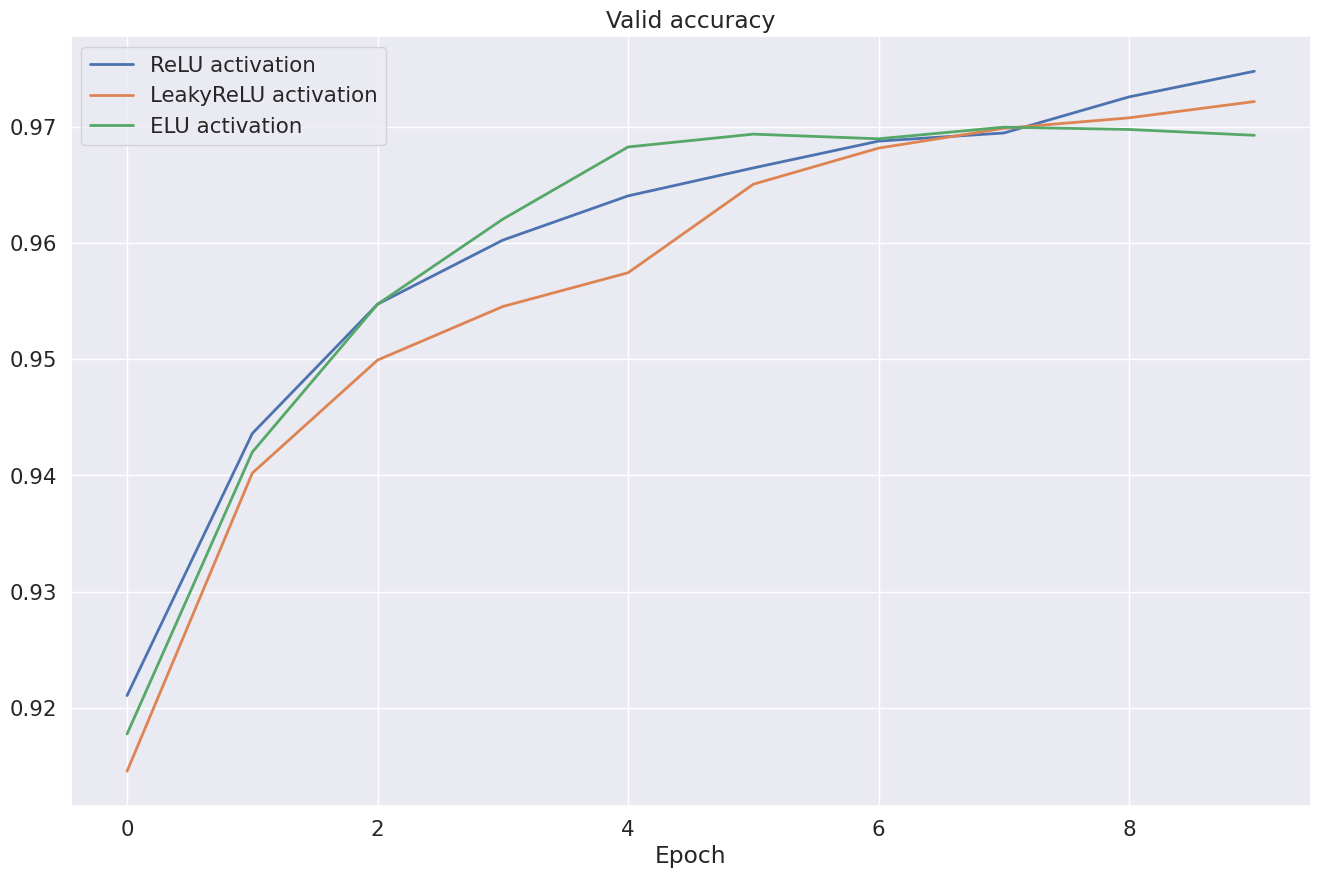

In [111]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [112]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-04-03 22:12:48--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 144.76.208.75
Connecting to img.the-village.kz (img.the-village.kz)|144.76.208.75|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg [following]
--2023-04-03 22:12:49--  https://img.the-village-kz.com/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village-kz.com (img.the-village-kz.com)... 104.21.1.92, 172.67.128.246, 2606:4700:3030::6815:15c, ...
Connecting to img.the-village-kz.com (img.the-village-kz.com)|104.21.1.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48,18K  --.-KB/s    in 0,06s   

2023-04-03 22:12:50 (81

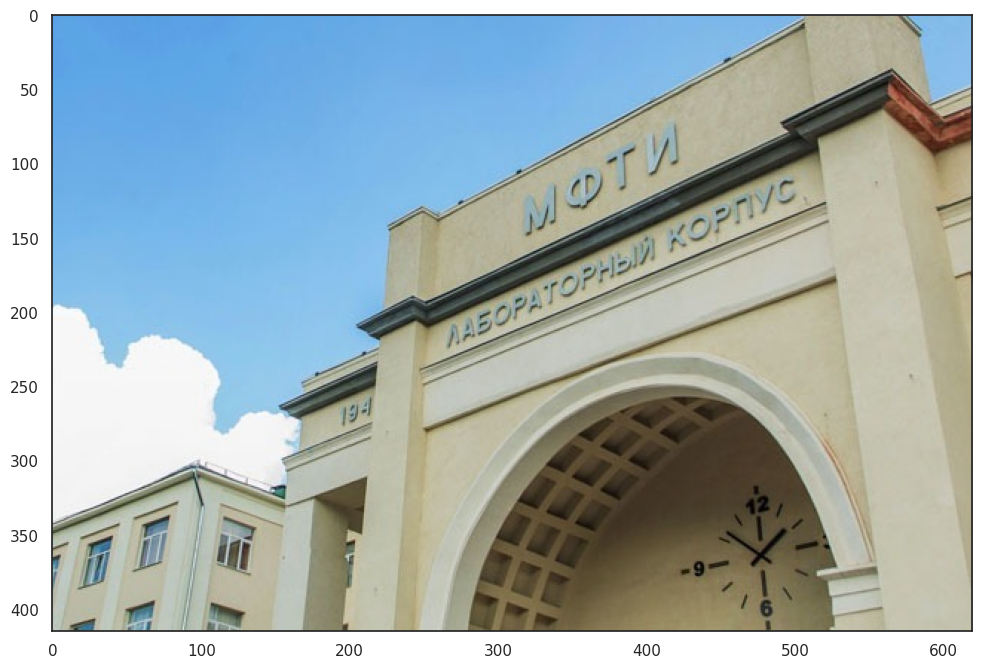

In [113]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте 
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [114]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
     [0, 1, 0],
     [1, -4, 1],
     [0, 1, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)
kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size
result = F.conv2d(img_t, kernel)[0]  #



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


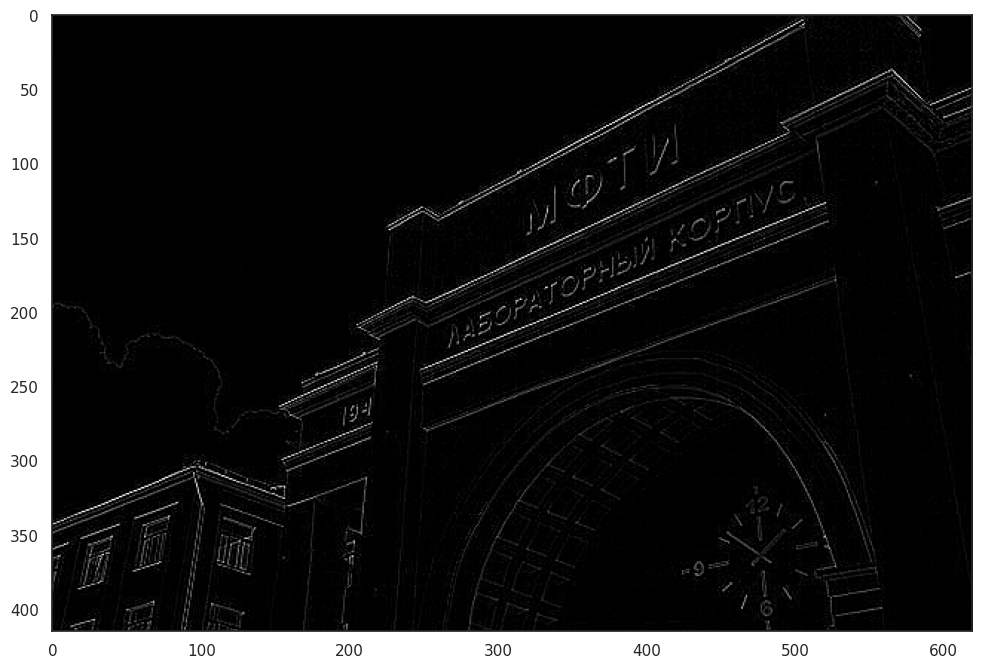

In [115]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3


plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
1) Е)
2) Д)
3) А)
4) В)
5) Б)
6) Г)



### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential). 

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [116]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2)#YOUR CODE
        self.fc1 = nn.Linear(5 * 5 * 16, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 5 * 5 * 16)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [117]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [118]:

criterion =  nn.CrossEntropyLoss()#YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
            # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                model.train()
                optimizer.zero_grad()
                outp = model(x_batch)

            else:
            # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                model.eval()
                with torch.no_grad():
                    outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all = y_batch.shape[0] # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                # делаем шаг градиентного спуска
                loss.backward()
                optimizer.step()

        if k == "train":
            print(f"Epoch: {epoch + 1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct / epoch_all}")
        accuracy[k].append(epoch_correct / epoch_all) 

Epoch: 1
Loader: train. Accuracy: 0.8672876602564102
Loader: valid. Accuracy: 0.9606370192307693
Epoch: 2
Loader: train. Accuracy: 0.9668970352564102
Loader: valid. Accuracy: 0.9762620192307693
Epoch: 3
Loader: train. Accuracy: 0.9772636217948718
Loader: valid. Accuracy: 0.9784655448717948
Epoch: 4
Loader: train. Accuracy: 0.9821714743589743
Loader: valid. Accuracy: 0.9807692307692307
Epoch: 5
Loader: train. Accuracy: 0.9845753205128205
Loader: valid. Accuracy: 0.9824719551282052
Epoch: 6
Loader: train. Accuracy: 0.9867621527777778
Loader: valid. Accuracy: 0.9849759615384616
Epoch: 7
Loader: train. Accuracy: 0.9889990651709402
Loader: valid. Accuracy: 0.9845753205128205
Epoch: 8
Loader: train. Accuracy: 0.9909855769230769
Loader: valid. Accuracy: 0.9842748397435898
Epoch: 9
Loader: train. Accuracy: 0.9919871794871795
Loader: valid. Accuracy: 0.9845753205128205
Epoch: 10
Loader: train. Accuracy: 0.9932224893162394
Loader: valid. Accuracy: 0.9856770833333334


In [119]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

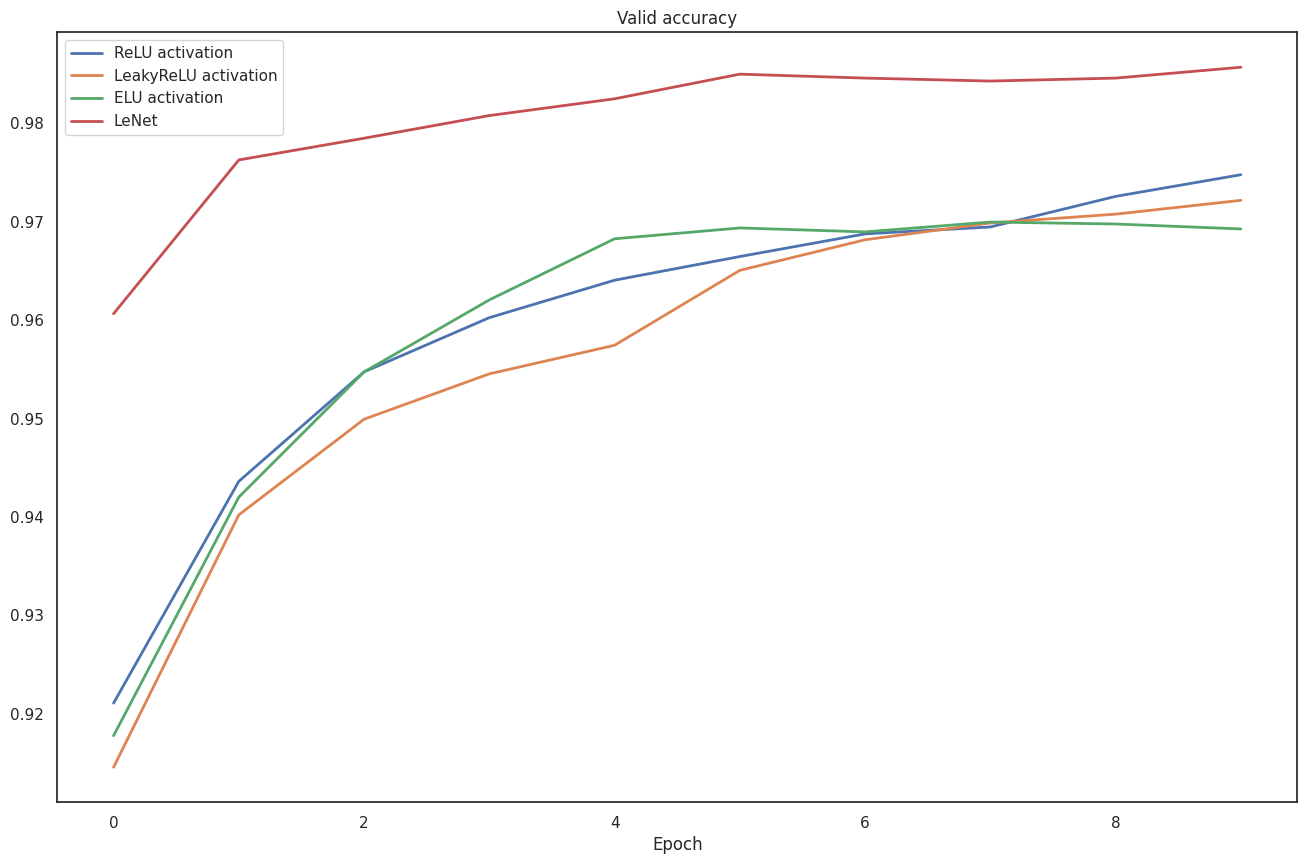

In [120]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:**

In [ ]:
0.99